# Processing each sample individually

In [10]:
import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244"
pltdir = wdir + "/plots/"
srldir = wdir + "/objects/"
degdir = wdir + "/deg_list/"

# processed_adata = sc.read_h5ad(srldir + 'processed_adata.h5ad')
# raw_adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')
with open(srldir + 'individual_adatas_allcells.pkl', 'rb') as f:
    adatas = dill.load(f)

# Generating and processing adata without downsampling

- No downsampling, uses all cells
- Clusters using a range of resolutions from 0 - 2 in increments of 0.2
    - Resolution 0.8 seems to show distrinct clusters enough for a level 1 cell typing

In [7]:
def process_adata(adata):
    
    # Filtering out mitochondrial and Ig genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ig"] = adata.var_names.str.contains("^IG")
    
    adata = adata[:, (adata.var['mt'] == False) & (adata.var['ig'] == False)]

    # Applying scanpy processing pipeline
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt", "ig"],
        inplace=True,
        log1p=True
    )

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        batch_key="sample"
    )
    sc.tl.pca(adata)

    X = adata.obsm['X_pca'].astype(np.float64)

    harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')

    adata.obsm['X_pca'] = harmony_out.Z_corr.T

    sc.pp.neighbors(adata)
    sc.tl.draw_graph(adata)
    sc.tl.umap(adata)

    res_range = np.round(np.arange(0, 2.2, 0.2), 1)
    
    for res in res_range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )
    
    sc.tl.paga(adata, groups='leiden_0_8') # Leiden reoslution 0.8 shows good distrinct clusters
    sc.tl.rank_genes_groups(
        adata, 
        groupby="leiden_0_8", 
        method="wilcoxon"
    )

    sc.tl.diffmap(adata)

    return adata

In [8]:
raw_adatas = {
    name: raw_adata[raw_adata.obs['sample_type'] == name] for name in list(raw_adata.obs['sample_type'].unique())
}

adatas = {
    name: process_adata(data).copy() for name, data in raw_adatas.items()
}

with open(srldir + 'individual_adatas_allcells.pkl', 'wb') as f:
    dill.dump(adatas, f)

# Individual sample UMAPs

- Shows UMAPs of each samples without downsampling
- Uses "leiden_0_8" for clustering resolution for all samples
    - Should optimize clustering resolution for each sample rather than using one resolution for all samples

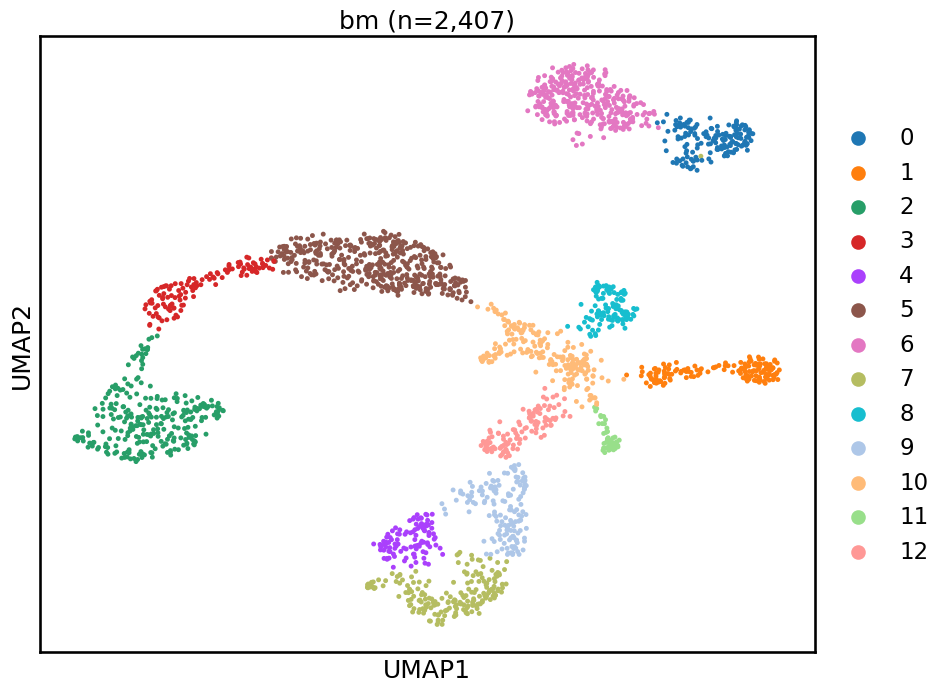

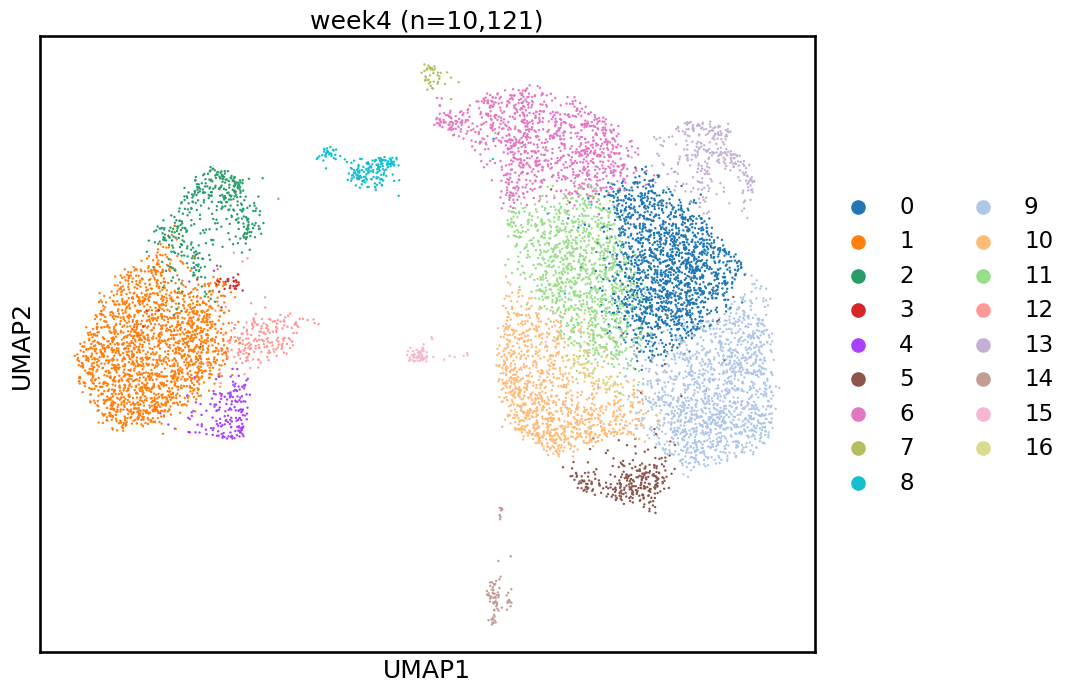

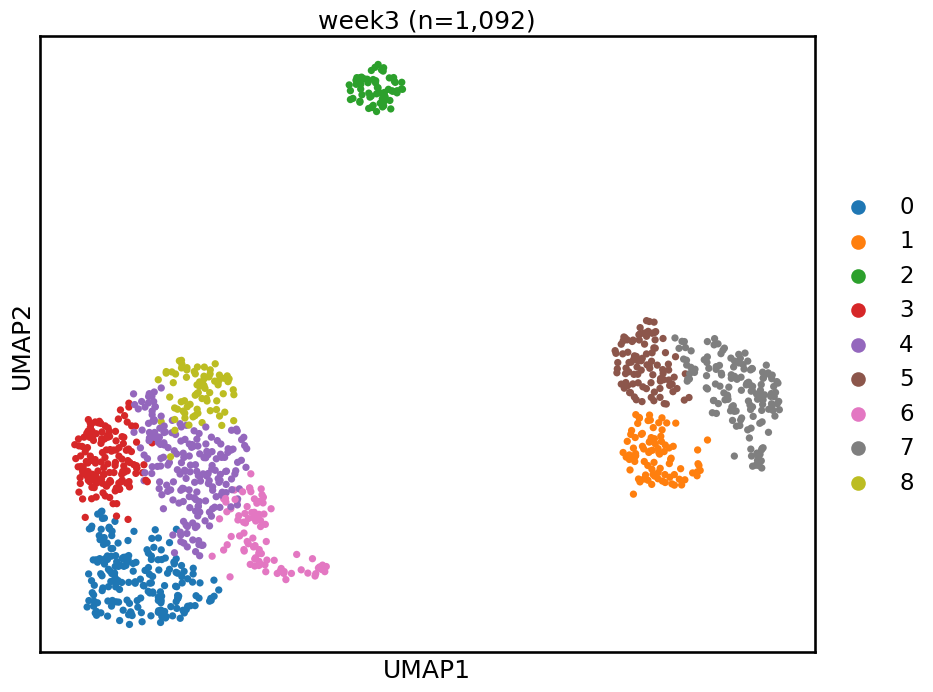

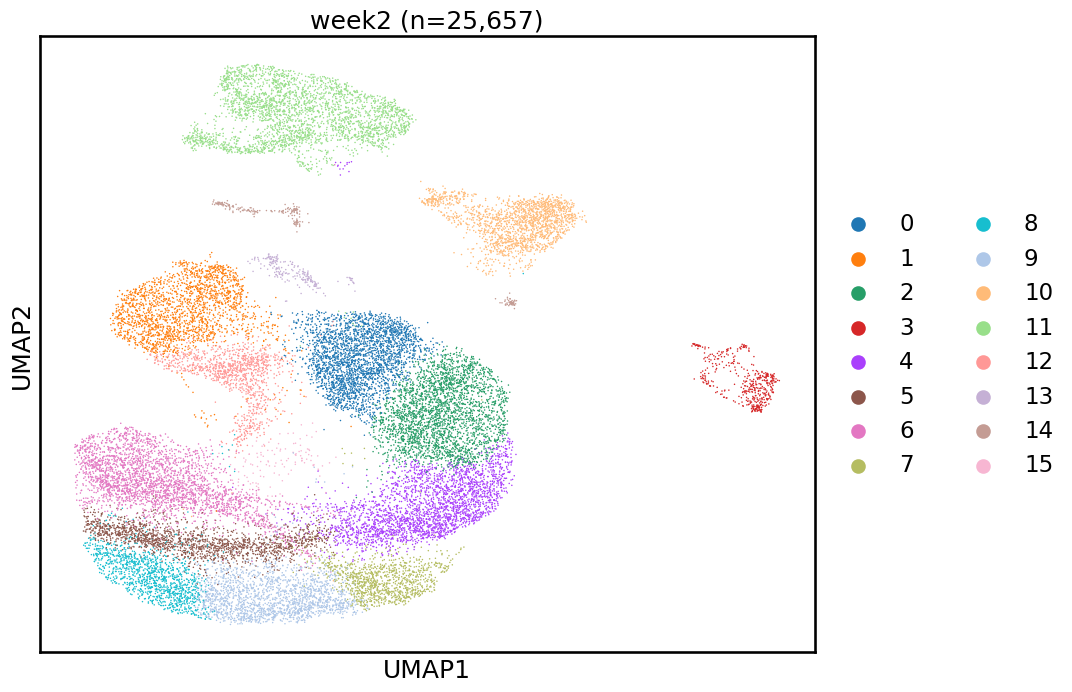

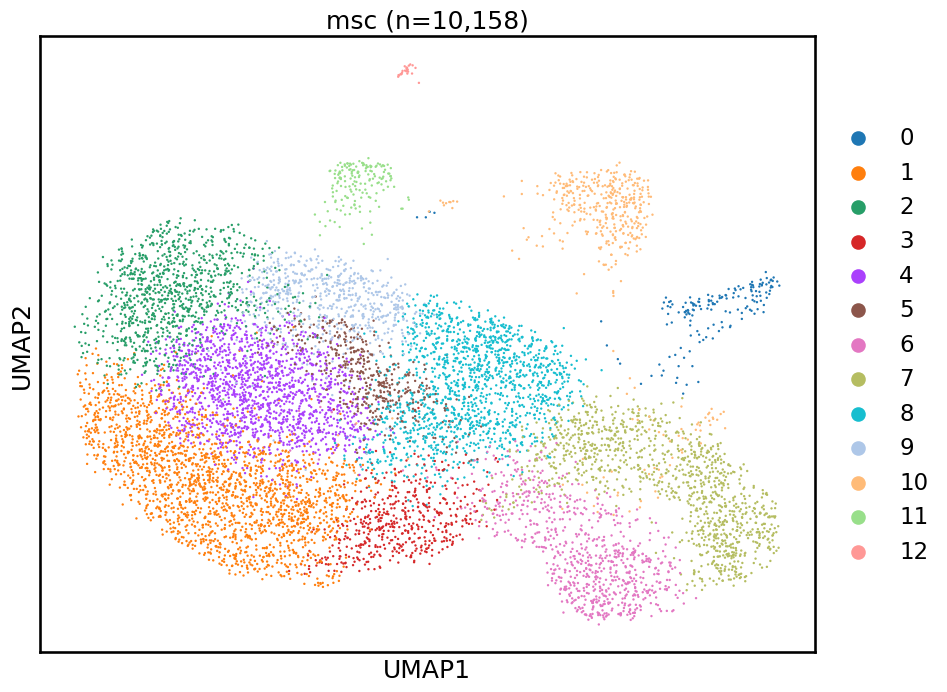

In [10]:
types = ['week2', 'week3', 'week4', 'bm', 'msc']

for name, data in adatas.items():
    fig, ax = plt.subplots(figsize=(10, 8))
    ncells = len(data)
    label = data.obs['name'].unique()[0]
    sc.pl.umap(
        data,
        color='leiden_0_8',
        show=False,
        ax=ax,
        title=f'{name} (n={ncells:,})'
    )
    fig.savefig(pltdir + f'{name}_UMAP_allcells.pdf', bbox_inches='tight', dpi=300)

Text(0.5, 0.93, 'Individually processed adatas w/o downsampling leiden 0.8')

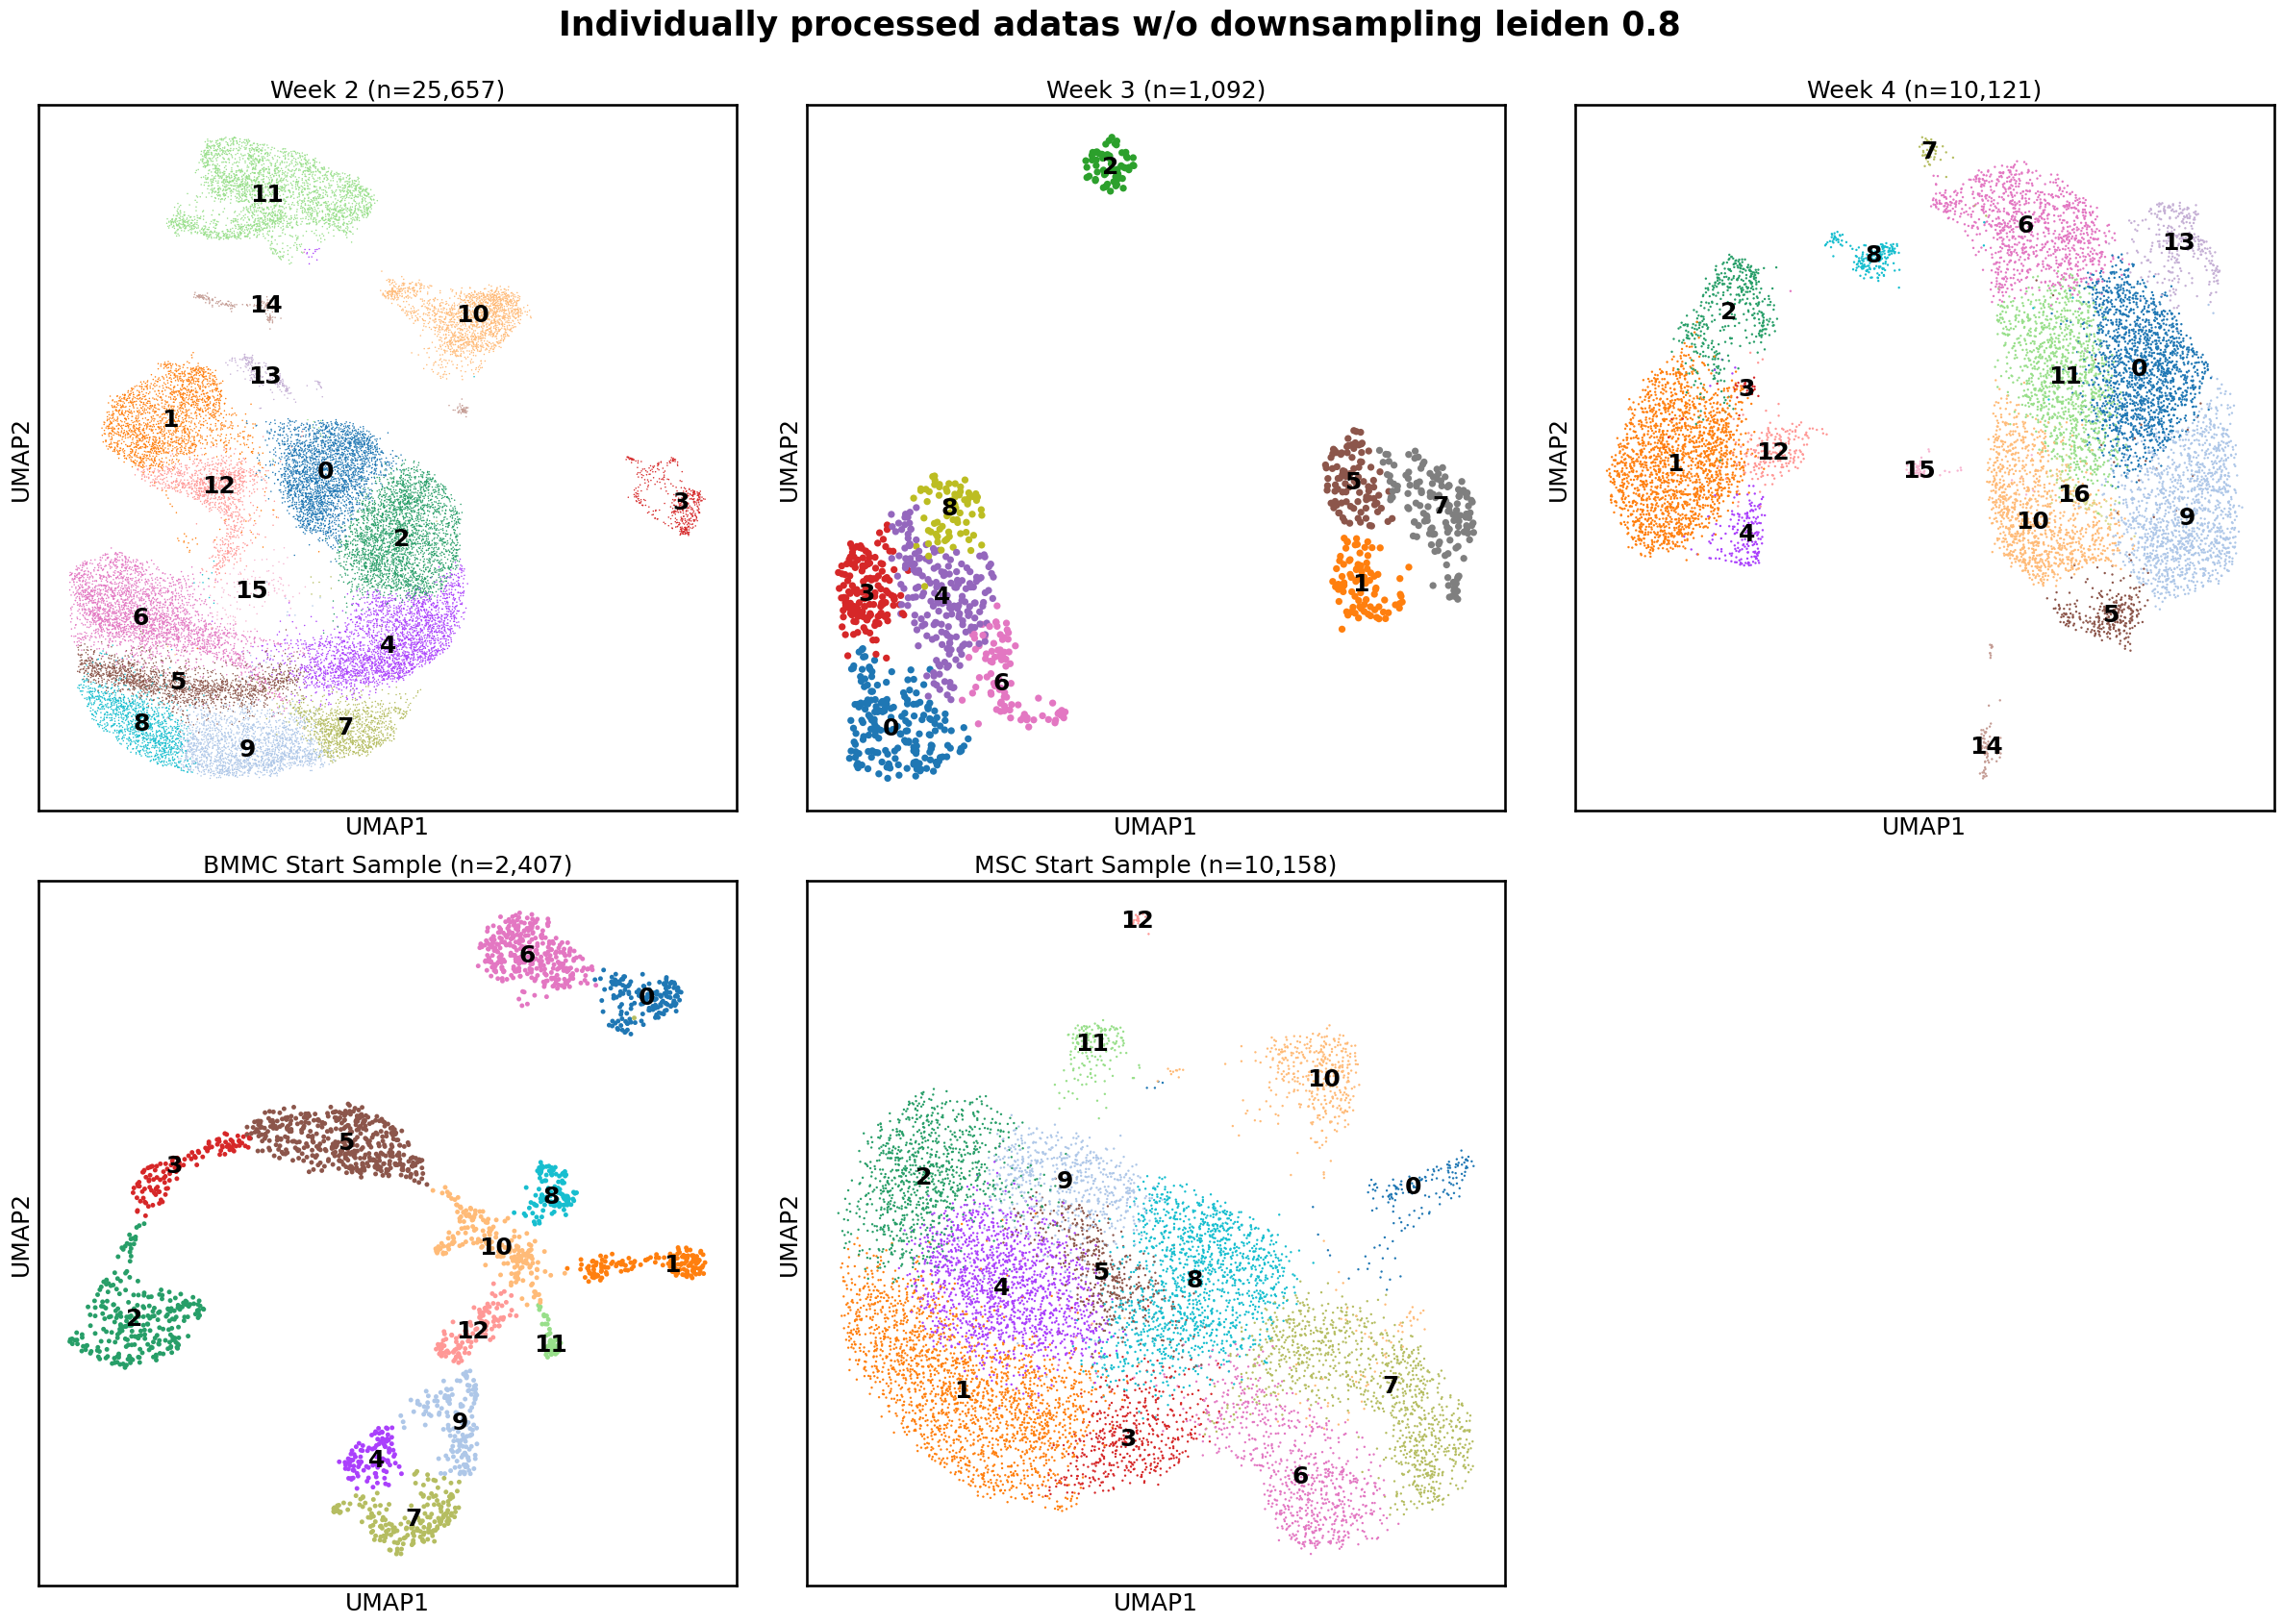

In [12]:
types = ['week2', 'week3', 'week4', 'bm', 'msc']

fig, ax, indices = subplot_grids(len(types), subplot_size=10, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, sample_type in zip(indices, types):
    data = adatas[sample_type]
    mask = data.obs['sample_type'] == sample_type
    cell_num = len(data[data.obs['sample_type'] == sample_type])
    label = data[data.obs['sample_type'] == sample_type].obs['names'].unique()[0]
    sc.pl.umap(
        data[mask],
        color='leiden_0_8',
        title=f'{label} (n={cell_num:,})',
        show=False,
        ax=ax[i],
        legend_loc='on data'
    )

fig.suptitle('Individually processed adatas w/o downsampling leiden 0.8', fontsize=25, y=0.93, weight='bold')

# fig.savefig(pltdir + f'{name}_UMAP_allcells.pdf', bbox_inches='tight', dpi=300)

# Individual sample DEG's

In [11]:
types = ['week2', 'week3', 'week4', 'bm', 'msc']

for sample_type in types:
    data = adatas[sample_type]
    mask = data.obs['sample_type'] == sample_type
    ranking = data[mask].uns['rank_genes_groups']
    gene_names = ranking['names']
    gene_scores = ranking['scores']
    gene_pvals_adj = ranking['pvals_adj']
    clusters = gene_names.dtype.names
    
    de_genes = []
    for cluster in clusters:
        names = gene_names[cluster]
        scores = gene_scores[cluster]
        pvals_adj = gene_pvals_adj[cluster]
        for name, score, pval_adj in zip(names, scores, pvals_adj):
            if pval_adj < 0.05:
                de_genes.append((cluster, name, score, pval_adj))
    
    df_de_genes = pd.DataFrame(de_genes, columns=['Cluster', 'Gene', 'Score', 'Adjusted p-value'])
    df_de_genes.to_csv(degdir + f'individually_processed/{sample_type}_DEGs.csv', index=False)